In [2]:
import gc
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))
print(tf.reduce_sum(tf.random.normal([1000, 1000])))
from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data

from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError
import keras_tuner

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr

from plots import *
from Experiment import *

%load_ext autoreload
%autoreload 2

2023-08-11 11:58:53.127550: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 11:58:55.864462: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


[]
tf.Tensor(235.9184, shape=(), dtype=float32)


In [3]:
# da = xr.open_dataarray('/Users/bandelol/Library/CloudStorage/OneDrive-UniversitaetBern/Documents/GIUB/code/z_anom.nc')
da = xr.open_dataarray('/storage/scratch/users/hb22g102/ERA5/Geopotential/500/box_-60_60_20_80/doy_doywin30/timewin9/z_anom.nc')[:, :-1, :-1]
da = da.sel(time=da.time.dt.season=='JJA')
X = da.values
X = X.reshape(*X.shape, 1)
minX, maxX = X.min(axis=0), X.max(axis=0)
X = (X - minX[None, ...]) / (maxX - minX)[None, ...]

norm = np.sqrt(degcos(da.lat.values[None, :, None, None]))

# DESOM

In [ ]:
from keras.metrics import Mean
from keras.losses import binary_crossentropy
class Desom(Model):
    def __init__(self, encoder, decoder, som_layer, norm = 1, factors  = None, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.som_layer = som_layer
        if factors is None:
            factors = [1, 1]
        self.factors = factors
        self.total_loss_tracker = Mean(name="total_loss")
        self.reconstruction_loss_tracker = Mean(
            name="reconstruction_loss"
        )
        # self.orthogonal_loss_tracker = Mean(name="orthogonal_loss")
        self.som_loss_tracker = Mean(name="som_loss")
        self.norm = tf.constant(norm)
        embeddings = self.decoder(tf.eye(self.decoder.input.shape[-1]))
        embeddings = tf.reshape(embeddings, (embeddings.shape[0], -1))
        self.embedding_norm = tf.reduce_mean(tf.linalg.norm(embeddings, axis=1)).numpy()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            # self.orthogonal_loss_tracker,
            self.som_loss_tracker,
        ]

    def train_step(self, data):
        x = data[0]
        with tf.GradientTape() as tape:
            z = self.som_layer(self.encoder(x))
            som_loss = self.som_layer.losses[0]
            reconstruction = self.decoder(z)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_mean(
            #         binary_crossentropy(data, reconstruction), axis=(1, 2)
            #     )
            # )
            reconstruction_loss = tf.reduce_mean(
                tf.math.reduce_euclidean_norm(
                    (x - reconstruction) * self.norm, axis=(1, 2, 3)
                )
            )
            # embeddings = self.decoder(tf.eye(self.decoder.input.shape[-1]))
            # embeddings = tf.reshape(embeddings, (embeddings.shape[0], -1))
            # arr = embeddings @ tf.transpose(embeddings)
            # orthogonal_loss = tf.reduce_sum(tf.abs(arr - self.embedding_norm * tf.eye(embeddings.shape[0])))
            # total_loss = self.factors[0] * reconstruction_loss + self.factors[1] * orthogonal_loss + self.factors[2] * som_loss
            total_loss = self.factors[0] * reconstruction_loss + self.factors[1] * som_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        # self.orthogonal_loss_tracker.update_state(orthogonal_loss)
        self.som_loss_tracker.update_state(som_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            # "orthogonal_loss": self.orthogonal_loss_tracker.result(),
            "som_loss": self.som_loss_tracker.result(),
        }
        
    def test_step(self, data):
        x = data[0]
        z = self.encoder(x)
        reconstruction = self.decoder(z)
        som_loss = self.som_layer(z)
        reconstruction_loss = tf.reduce_mean(
            tf.math.reduce_euclidean_norm(
                (x - reconstruction) * self.norm, axis=(1, 2, 3)
            )
        )
        
        return {
            "reconstruction_loss": reconstruction_loss,
            "som_loss": som_loss,
        }

In [ ]:
from functools import partial

def create_model_(hp, input_shape, batch_norm = True, tied_weights = False):
    map_size = (6, 6)
    latent_dim = hp.Int("latent_dim", min_value=5, max_value=50, step=5)
    
    filter_specs = [
        ([8, 8, 8], [7, 5, 3], [4, 3, 2]),
        ([16, 16, 16], [7, 5, 3], [4, 3, 2]),
        ([32, 32, 32], [7, 5, 3], [4, 3, 2]),
        ([64, 64, 64], [7, 5, 3], [4, 3, 2]),
        ([16, 32, 64], [7, 5, 3], [4, 3, 2]),
        ([8, 16, 32], [7, 5, 3], [4, 3, 2]),
        ([8, 8, 8], [3, 3, 3], [2, 2, 2]),
        ([16, 16, 16], [3, 3, 3], [2, 2, 2]),
        ([32, 32, 32], [3, 3, 3], [2, 2, 2]),
        ([64, 64, 64], [3, 3, 3], [2, 2, 2]),
        ([16, 32, 64], [3, 3, 3], [2, 2, 2]),
        ([8, 16, 32], [3, 3, 3], [2, 2, 2]),
    ]
    filter_specs_ind = hp.Int("filter_specs_ind", min_value=0, max_value=len(filter_specs) - 1, step=1)
    encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, *filter_specs[filter_specs_ind], 1, batchnorm=batch_norm, tied_weights=tied_weights)
    som_layer = SOMLayer(map_size, name='som')
    
    desom = Desom(encoder, decoder, som_layer, norm=norm, factors=[1, 0, 0])
    desom.layers[-1].trainable = False
    desom.compile()
    return desom

create_model = partial(create_model_, input_shape=X.shape[1:], batch_norm=True, tied_weights=False)

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel=create_model,
    objective=keras_tuner.Objective("reconstruction_loss", direction="min"),
    max_trials=20,
    executions_per_trial=1,
    overwrite=False,
    directory="results/tmp",
    project_name="desom_ae",
    distribution_strategy=tf.distribute.MirroredStrategy(['/gpu:0'])
)

X_train, X_test = train_test_split(X, test_size=0.1)

In [ ]:
epochs = 10
batch_size = 32

tuner.search(X_train, X_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, X_test))


In [ ]:
desom = tuner.get_best_models()[0]

In [ ]:
desom.som_layer = SOMLayer((3, 3), name='som')
desom.layers[-1].trainable = True
for layer in desom.layers[:-1]:
    layer.trainable = False

desom.factors = [0, 1]
desom.compile()
desom.fit(X_train, X_train, epochs=20, batch_size=64, validation_data=(X_test, X_test))

In [ ]:
clu = Clusterplot(2, 5, region=(-60, 59.5, 20, 79.5))
indices = np.random.randint(0, X.shape[0], size=5)
theseX = X[indices]
theseXp = desom.decoder(desom.encoder(theseX))
allX = np.concatenate([theseX, theseXp])[..., 0]
allX = allX * (maxX - minX)[None, ..., 0] + minX[None, ..., 0]
allX = da[:10].copy(data=allX)
_ = clu.add_contourf(allX, cmap='bwr')

In [ ]:
latent_dim = desom.encoder.layers[-1].output_shape[1]

In [ ]:
from matplotlib.colors import LogNorm


fig, axes = plt.subplots(5, 10, figsize=(20, 4))
axes = axes.flatten()
theseX = desom.decoder(np.eye(latent_dim))
for i, x in enumerate(theseX):
    im = axes[i].imshow(x[:, :, 0], origin='lower', cmap='bwr')
    axes[i].axis('off')
fig.colorbar(im, ax=axes)

In [ ]:
Z = desom.encoder(X)

In [ ]:
bmus = desom.som_layer.get_bmus(Z).numpy()
mask = labels_to_mask(bmus)

In [ ]:
clu = Clusterplot(3, 3, region=(-60, 59.5, 20, 79.5), honeycomb=True)
clu.add_any_contour_from_mask(da, mask)

# KERASOM

In [153]:
from keras.callbacks import Callback
class CustomCallback(Callback):
    def __init__(self, epochs, start_sigma = None):
        super().__init__()
        self.epochs = epochs
        self.start_sigma = start_sigma
        
    def on_train_begin(self, logs=None):
        if self.start_sigma is None:
            map_size = self.model.som_layer.map_size
            self.start_sigma = max(map_size[0], map_size[1]) / 2
        self.tau = self.epochs / np.log(self.start_sigma)
        self.model.som_layer.sigma = self.start_sigma

    def on_epoch_begin(self, epoch, logs=None):
        self.model.som_layer.sigma = self.start_sigma * np.exp(-epoch / self.tau)


class Kerasom(Model):
    def __init__(self, som_layer, **kwargs):
        super().__init__(**kwargs)
        self.som_layer = som_layer
        self.som_loss_tracker = Mean(name="som_loss")

    @property
    def metrics(self):
        return [
            self.som_loss_tracker,
        ]

    def train_step(self, data):
        x = data[0]
        with tf.GradientTape() as tape:
            bmus = self.som_layer(x)
            som_loss = self.som_layer.losses[0]
            grads = tape.gradient(som_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.som_loss_tracker.update_state(som_loss)
        return {
            "som_loss": tf.reduce_mean(som_loss),
        }
        
    def test_step(self, data):
        x = data[0]
        bmus = self.som_layer(x)
        som_loss = self.som_layer.losses[0]
        return {
            "som_loss": tf.reduce_mean(som_loss),
        }

In [76]:
from sklearn.decomposition import PCA
n_pcas = 11
pca = PCA(n_pcas)
X_flat = pca.fit_transform(X.reshape(X.shape[0], -1))

In [156]:
from keras.optimizers import Adam, Adadelta, SGD
from tqdm.keras import TqdmCallback

map_size = (8, 8)
som_layer = SOMLayer(map_size)
som_layer.build(input_shape=X_flat.shape)
som_layer.set_weights([X_flat[np.random.choice(X_flat.shape[0], size=np.prod(map_size), replace=False)]])
model = Kerasom(som_layer)
model.compile(optimizer=SGD(learning_rate=0.01))
epochs = 500
model.fit(X_flat, np.zeros(X_flat.shape[0]), epochs=epochs, batch_size=X_flat.shape[0], validation_split=0.1, verbose=0, callbacks=[TqdmCallback(), CustomCallback(epochs, 4)])

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

In [147]:
bmus = model.som_layer(X_flat)
loss = model.som_layer.losses[0].numpy()

In [148]:
print(model.som_layer.h)

tf.Tensor(
[[0.19947252 0.17603357 0.12098536 ... 0.06475824 0.12098536 0.17603357]
 [0.17603357 0.19947252 0.17603357 ... 0.02699492 0.06475824 0.12098536]
 [0.12098536 0.17603357 0.19947252 ... 0.06475824 0.02699492 0.06475824]
 ...
 [0.06475824 0.02699492 0.06475824 ... 0.19947252 0.17603357 0.12098536]
 [0.12098536 0.06475824 0.02699492 ... 0.17603357 0.19947252 0.17603357]
 [0.17603357 0.12098536 0.06475824 ... 0.12098536 0.17603357 0.19947252]], shape=(64, 64), dtype=float32)


In [149]:
nodes = pca.inverse_transform(model.layers[-1].prototypes.numpy()).reshape(-1, *X.shape[1:3])

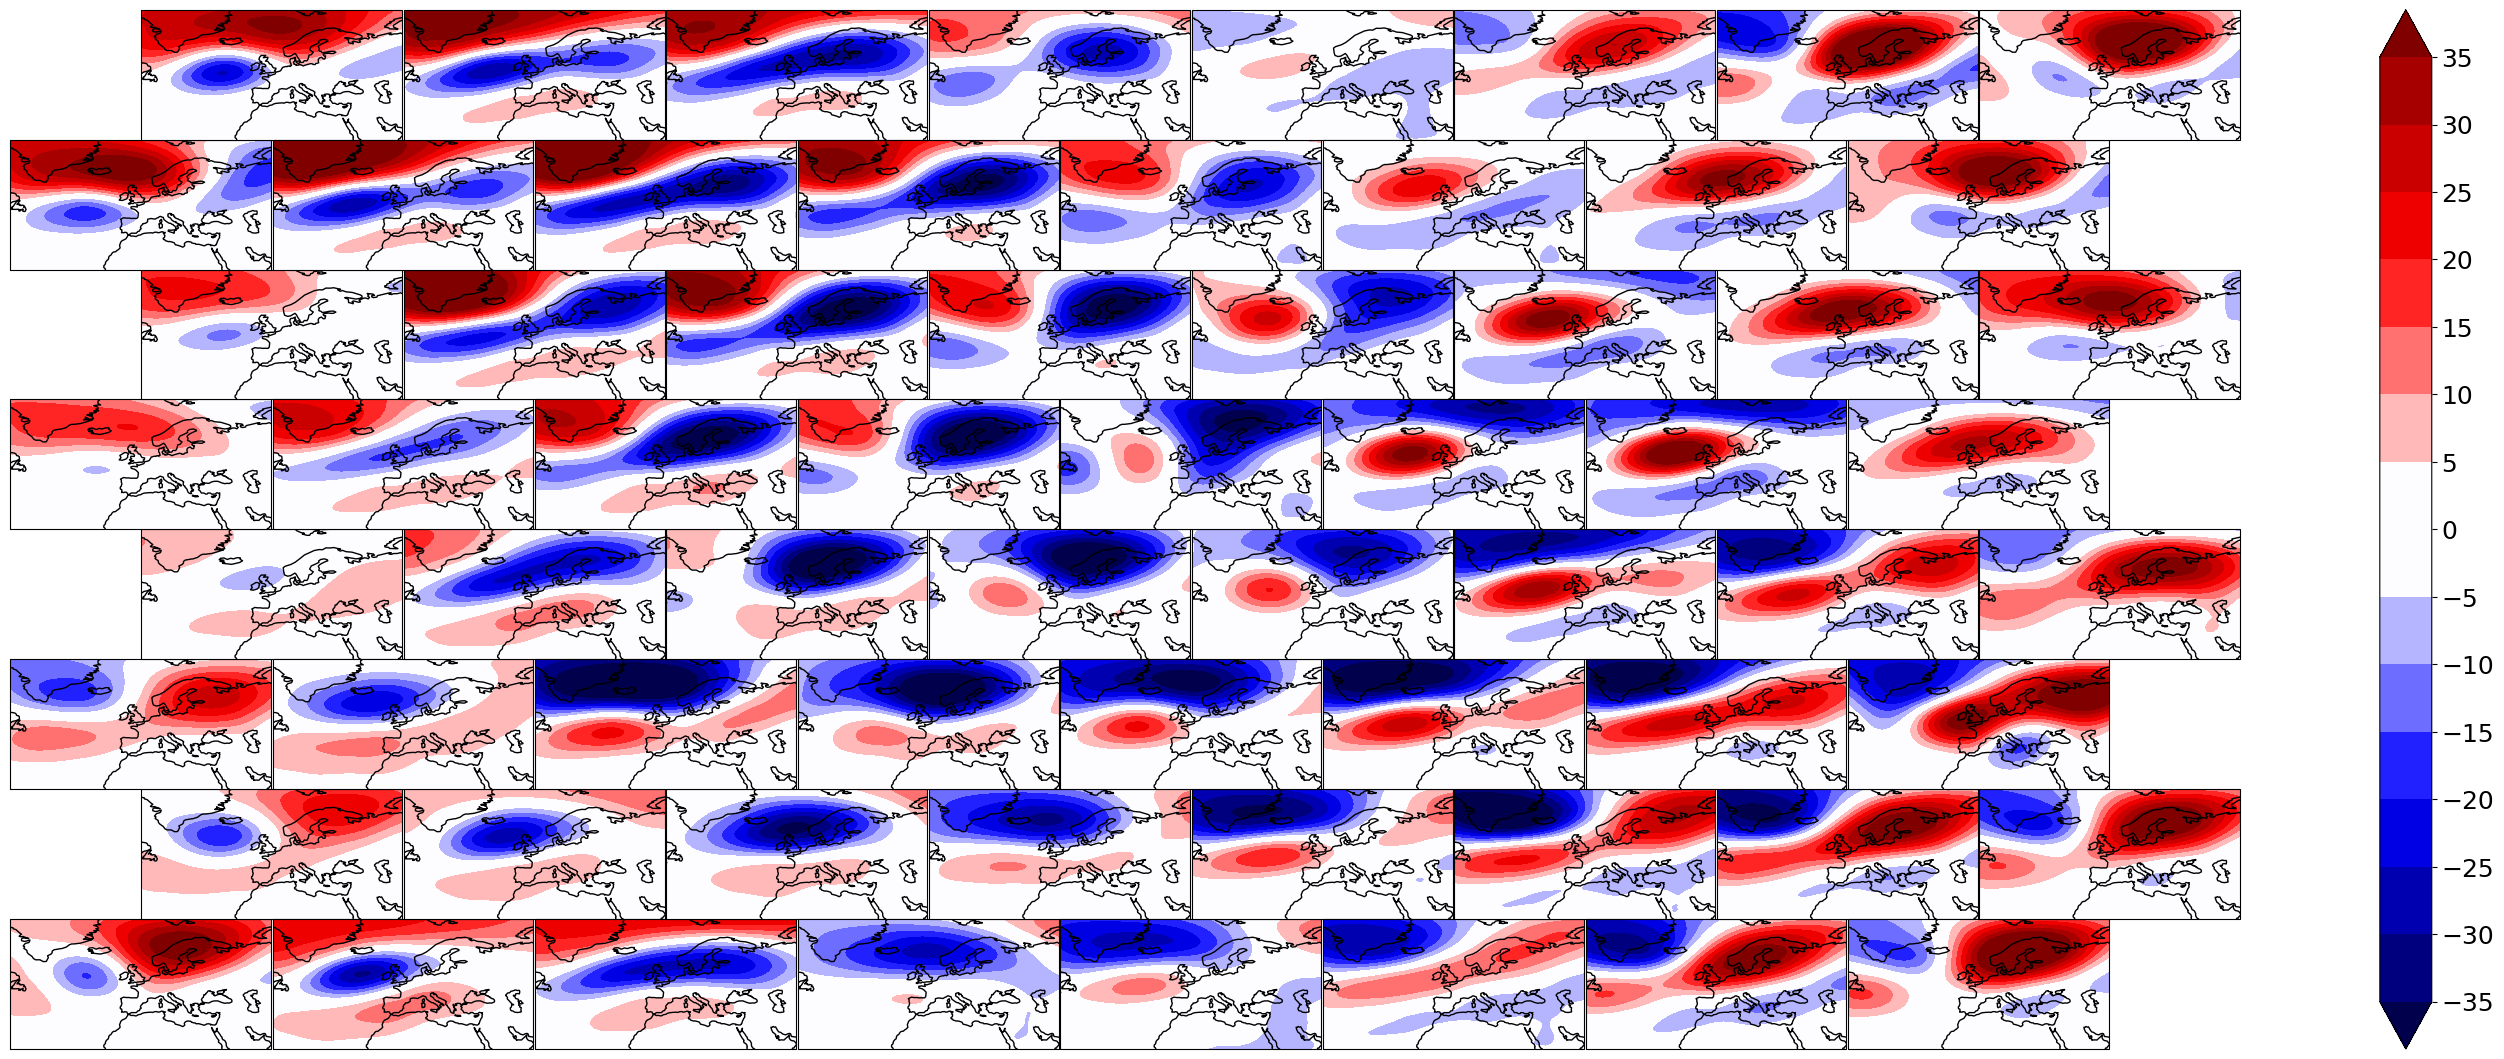

In [150]:
clu = Clusterplot(*map_size, honeycomb=True, region=(-60, 59.5, 20, 79.5))
weights_da = da[:np.prod(map_size)].copy(data=nodes * (maxX - minX)[None, ..., 0] + minX[None, ..., 0])
# clu.add_any_contour_from_mask(da, labels_to_mask(bmus.numpy()))
_ = clu.add_contourf(weights_da)

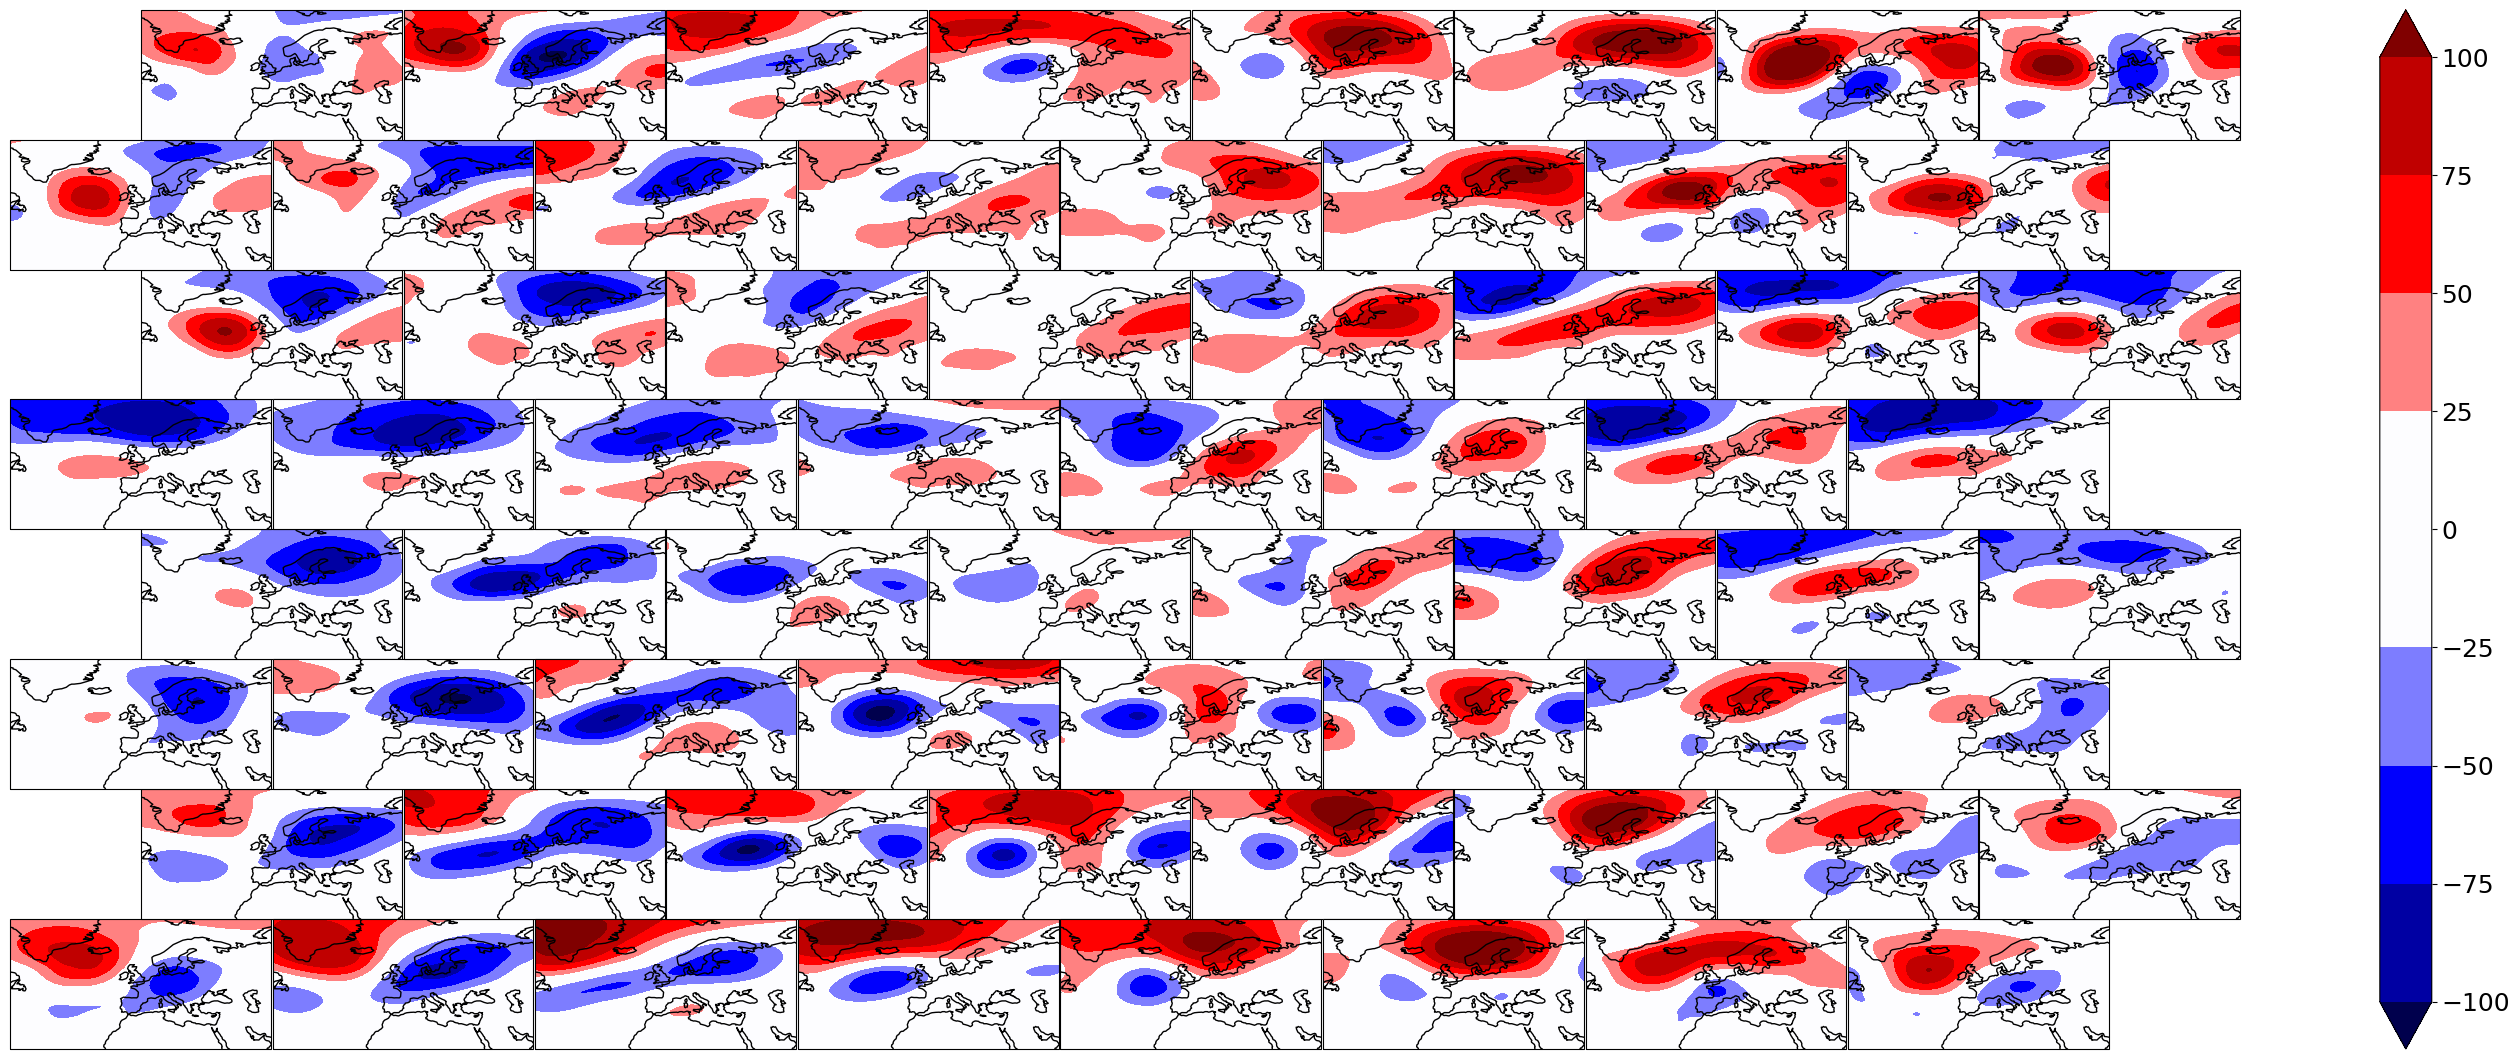

In [123]:
clu = Clusterplot(*map_size, honeycomb=True, region=(-60, 59.5, 20, 79.5))
_ = clu.add_any_contour_from_mask(da, labels_to_mask(bmus.numpy()))

In [105]:
net = SOMNet(*map_size, X_flat, PBC=True)
net.train(epochs=2000, start_learning_rate=0.05)

2023-08-11 13:06:00.544 | INFO     | simpsom.network:__init__:116 - Periodic Boundary Conditions active.
2023-08-11 13:06:00.544 | INFO     | simpsom.network:__init__:127 - Hexagonal topology.
2023-08-11 13:06:00.545 | INFO     | simpsom.network:_set_weights:211 - The weights will be initialized randomly.
2023-08-11 13:06:00.546 | INFO     | simpsom.network:train:363 - The map will be trained with the batch algorithm.


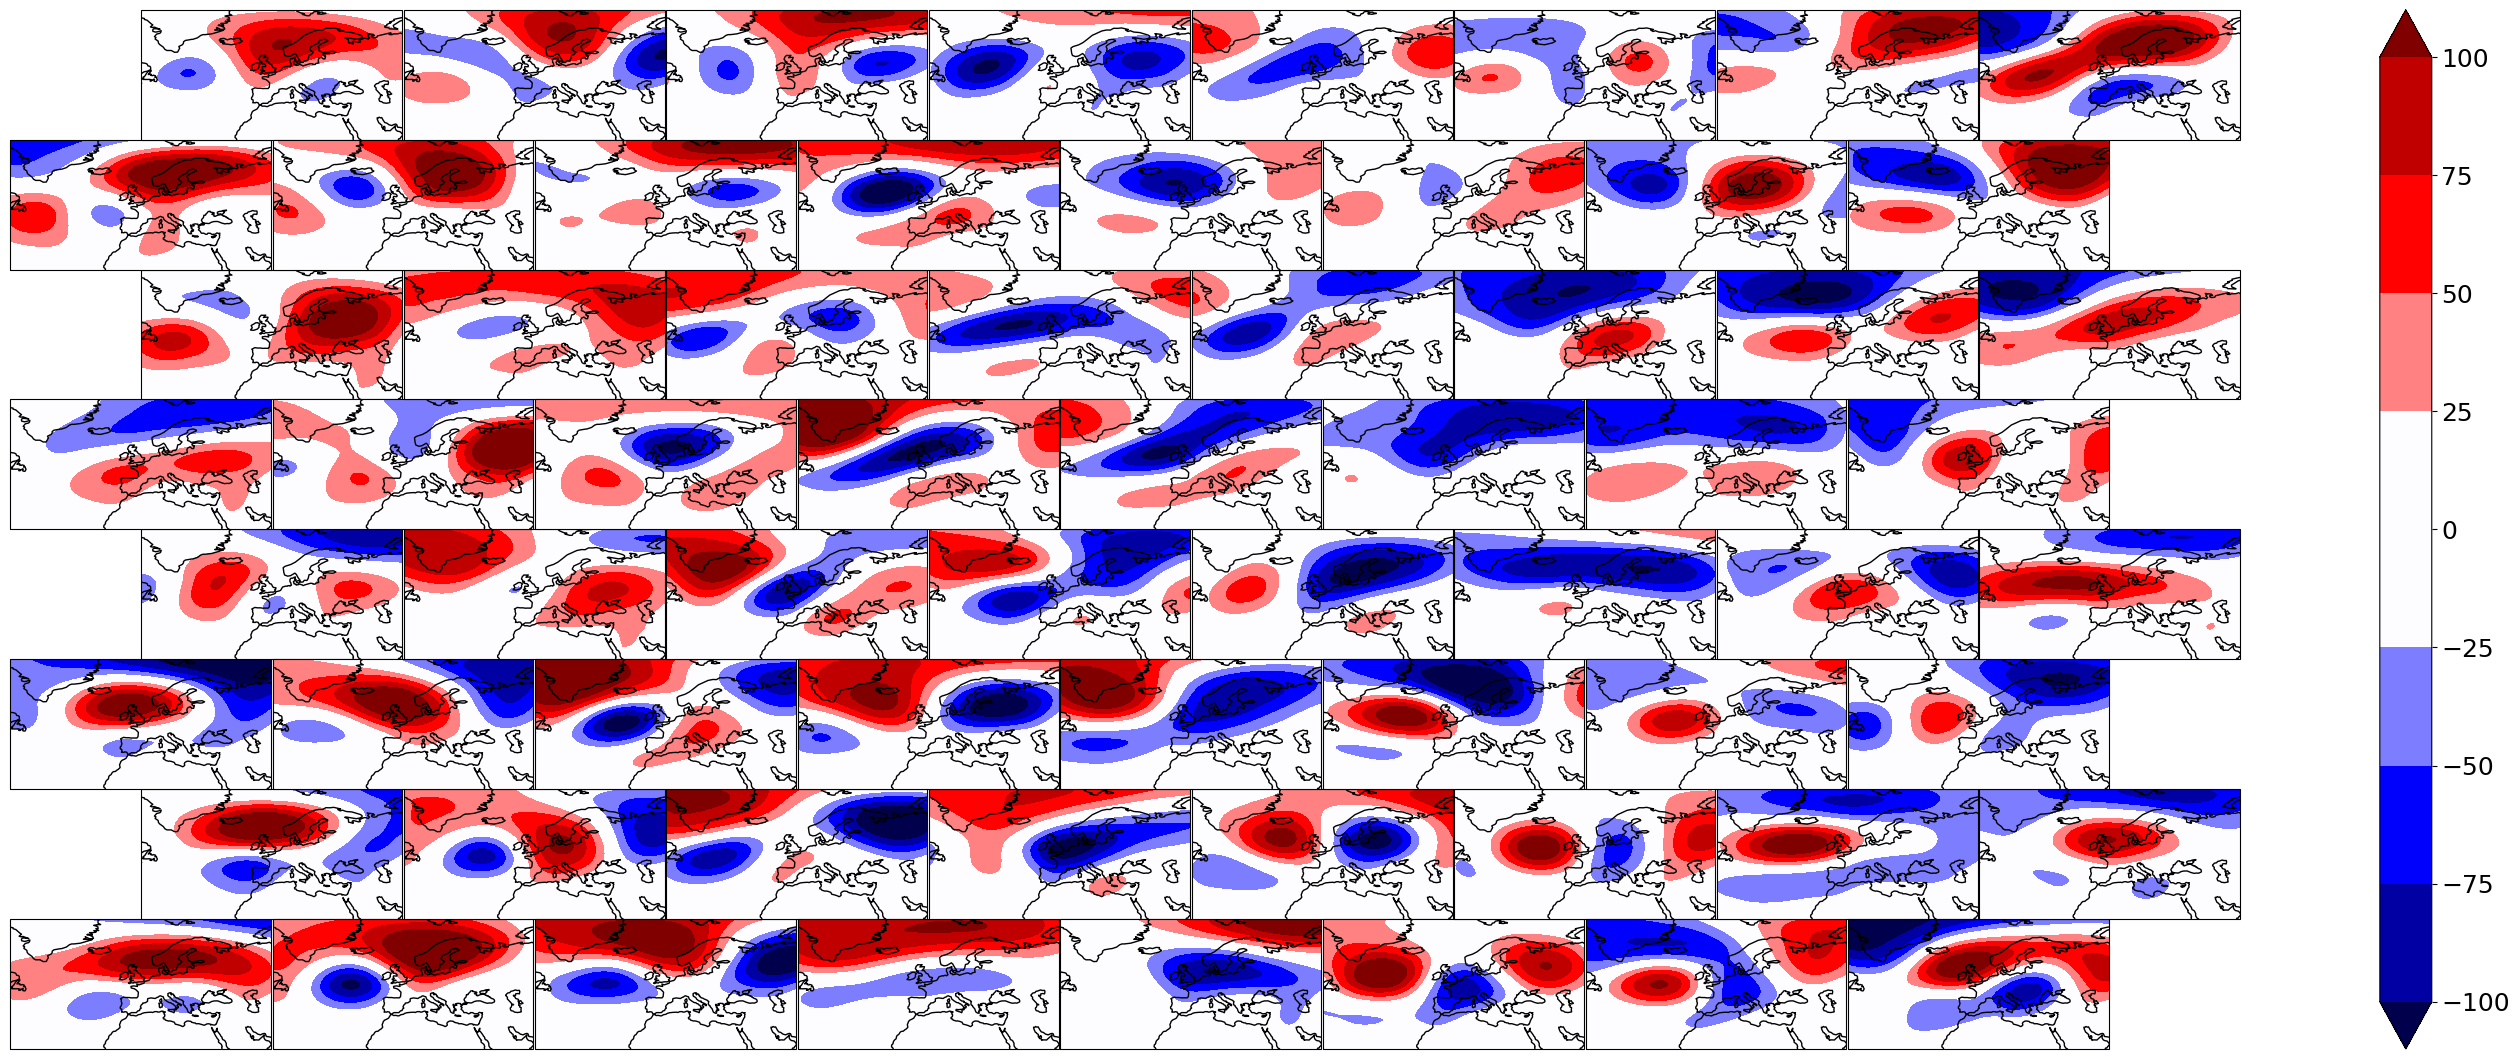

In [106]:
clu = Clusterplot(*map_size, honeycomb=True, region=(-60, 59.5, 20, 79.5))
weights_da = da[:np.prod(map_size)].copy(data=pca.inverse_transform(net.weights).reshape(-1, *X.shape[1:3]) * (maxX - minX)[None, ..., 0] + minX[None, ..., 0])
_ = clu.add_contourf(weights_da)

In [ ]:
exp_wind = ClusteringExperiment(
    'ERA5', 'Wind', '300', None, None, -60, 60, 25, 85, 
    'anomaly', 'JJA', 'none', None, 
    {'detrended': False, 'time': ('win', 15)}, inner_norm=None
)
da_abs = exp_wind.open_da('anomaly', season='JJA')
X = da_abs.values

In [ ]:
from simpsom.plots import add_cluster

def timeseries_on_map(timeseries: NDArray, labels: list | NDArray):
    timeseries = np.atleast_2d(timeseries)
    mask = labels_to_mask(labels)
    return np.asarray([[np.mean(timeseries_[mas]) for mas in mask.T] for timeseries_ in timeseries])

In [ ]:
net, centers, labels = exp_wind.compute_som(6, 6, 20, return_type=ADJUST_REALSPACE, train_kwargs=dict(train_algo='batch', epochs=1000, start_learning_rate=0.1))